In [23]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.integrate import quad

from time import perf_counter as time

from tqdm import tqdm
from scipy import linalg, stats

from scipy.special import jacobi, legendre, roots_jacobi, eval_jacobi, factorial, gamma

# from tb_utils import JacobiGL, constructV, constructVx, constructD, z2x, z2x_dz, x2z, x2z_dx, evaluate_jacobi_grid, constructMinv, jacobi_p_normalisation_const
from tb_utils import *
import itertools
from scipy.sparse import diags, kron, eye, spdiags

from scipy.integrate import solve_ivp
from tqdm import tqdm
import seaborn as sns
import scipy as sp

from time import perf_counter as time

import warnings
warnings.filterwarnings('ignore')

In [24]:
# def setup_plotting():
#     sns.set_theme(style="whitegrid", context="paper")
# setup_plotting()

## 2c-g) KdV equation

In [25]:
c = 1
x0 = 0
alpha = 25

def f_exact(x, c=c, x0=x0): return (c/2)*(1/np.cosh((1/2)*np.sqrt(c)*(x - x0)))**2
def u_exact(x, t): return f_exact(x - c*t)

def u_exact_z(z_2pi, t):
    x = (alpha/np.pi) * z_2pi - alpha
    return u_exact(x, t)

N_plot = 1000
T_plot = 3
t_linspace = np.linspace(0, T_plot, N_plot)
x_linspace = np.linspace(-alpha, alpha, N_plot)
X, T = np.meshgrid(x_linspace, t_linspace)
U_exact = u_exact(X, T)

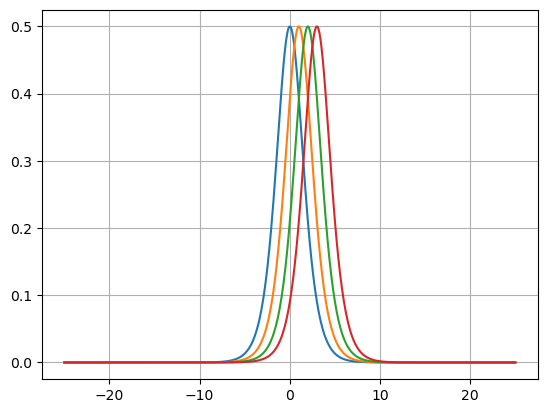

In [26]:
# fig, ax = plt.subplots(1, 1, figsize = (15, 5), subplot_kw={"projection": "3d"})
# ax.plot_surface(x_linspace, t_linspace, U_exact, linewidth=0, antialiased=False, label = "Exact Solution")

plt.plot(x_linspace, u_exact(x_linspace, 0), label = "t = 0")
plt.plot(x_linspace, u_exact(x_linspace, 1), label = "t = 0")
plt.plot(x_linspace, u_exact(x_linspace, 2), label = "t = 0");
plt.plot(x_linspace, u_exact(x_linspace, 3), label = "t = 0");
plt.grid();

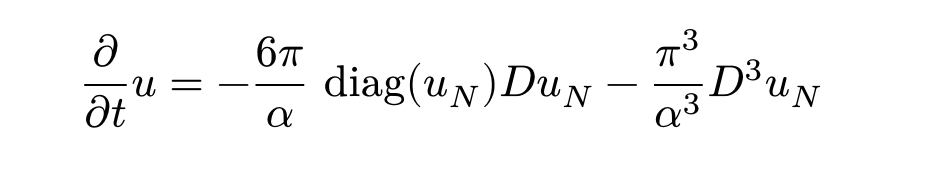

In [27]:
from functools import partial
from typing import Protocol

class BasisFunction(Protocol):
    def __call__(
        self, x: npt.NDArray[np.float64], n: int
    ) -> npt.NDArray[np.float64]: ...

def construct_vandermonde(
    x: npt.NDArray, N: int, basis_function: BasisFunction, dtype=np.float64
) -> npt.NDArray:
    """
    Construct the Vandermonde matrix V such that V[i,j] = phi_j(x_i),
    where phi_j is the j'th basis function evaluated at point x_i.
    """
    V = np.zeros((len(x), N), dtype=dtype)
    for j in range(N):
        V[:, j] = basis_function(x, j)
    return V


def trigonometric_polynomial(
    x: npt.NDArray, n: int, k: int, L: float
) -> npt.NDArray[np.float64]:
    """
    Evaluates the trigonometric polynomial of order `n` at points `x`.

    Arguments:
        x: Points at which to evaluate the polynomials, shape (m,)
        n: Order of polynomial to compute (must be non-negative)
        k: Order of derivative to compute (must be non-negative)
        L: Length of the domain

    Returns: Array of shape (m,)
    """
    freq = 2 * np.pi * n / L
    deriv_factor = (1j * freq) ** k
    return deriv_factor * np.exp(1j * freq * x)

N_grid = 100
# Basis functions
L = 2*np.pi
# basis_func = partial(trigonometric_polynomial_centered, k=0, N=N_grid, L=L)
# basis_func_grad = partial(trigonometric_polynomial_centered, k=1, N=N_grid, L=L)
basis_func = partial(trigonometric_polynomial, k=0, L=L)
basis_func_grad = partial(trigonometric_polynomial, k=1, L=L)

# Set up nodes
x = np.linspace(
    0, 2*np.pi, N_grid, endpoint=False
)  # No last point since we impose periodicity

V = construct_vandermonde(x, N_grid, basis_func, dtype=np.complex128)
V_x = construct_vandermonde(x, N_grid, basis_func_grad, dtype=np.complex128)
D = np.linalg.solve(V.T, V_x.T).T  # D = V_x * V^{-1}, right solve


### PERIODICTY !!!

In [28]:
# author: Jeppe
def trigonometric_polynomial(x, n: int, k: int, L: float):
    freq = 2 * np.pi * n / L
    deriv_factor = (1j * freq) ** k
    return deriv_factor * np.exp(1j * freq * x)

def trigonometric_polynomial_centered(x, n: int, k: int, N: int, L: float):
    "centered at n = N//2"
    n_offset = n - N // 2
    return trigonometric_polynomial(x=x, n=n_offset, k=k, L=L)

def constructV_Fourier(z: np.ndarray, k = 0):
    "Function for constructing the Vandermonde matrix, V_{ij} = P_j(x_i)"
    N = z.shape[0]
    V = np.zeros((N, N), dtype = np.complex128) # wow why is this complex?
    for n in range(N):
        # V[n, :] = trigonometric_polynomial_centered(x=z, n=N, k = 0, N=N, L=b - a)
        # V[n, :] = trigonometric_polynomial(x=z, n=n, k=k, L=2*np.pi)
        V[n, :] = trigonometric_polynomial_centered(x=z, n=n, k=k, N=N, L=2*np.pi)
    # V = np.sqrt(2 / (b - a)) * V
    # V = V * np.sqrt((2*np.arange(1,N+1))/(b - a))
    return V.T

In [33]:
N = 20
z_2pi = np.linspace(0, 2*np.pi, N, endpoint=False)
V = constructV_Fourier(z_2pi, k = 0)
Vx = constructV_Fourier(z_2pi, k = 1)
D_van = np.linalg.solve(V.T, Vx.T).T

D_van_3 = D_van @ D_van @ D_van

print("D matrix condition number (Fourier): ", np.linalg.cond(D_van))
print("D matrix condition number (Fourier): ", np.linalg.cond(D_van_3))

def v(x): return np.exp(np.sin(x))
def dv(x): return np.exp(np.sin(x)) * np.cos(x)

# def v(x): return np.cos(x)
# def dv(x): return -np.sin(x)

# def v(x): return np.cos(x)*np.where(x < 0, -1, 1) 
# def dv(x): return np.sin(x)*np.where(x < 0, 1, -1)

h = 2*np.pi / N
x_array = np.arange(N) * h

v_array = v(x_array)
dv_array = dv(x_array)

# print(v_array)
# print(dv_array)

D = get_D(N_input = N)
print("D matrix condition number Lagrange: ", np.linalg.cond(D))

dv_D = D @ v_array
dv_D_van = D_van.real @ v_array

print(np.linalg.norm(dv_array - dv_D, ord = np.inf))
print(np.linalg.norm(dv_array - dv_D_van, ord = np.inf))
print(np.linalg.norm(D_van.real - D))

D matrix condition number (Fourier):  2.3920592851665456e+16
D matrix condition number (Fourier):  4.4534707902386296e+16
D matrix condition number Lagrange:  3.2534168680982932e+16
4.987947832546524e-10
4.988010005035903e-10
4.025801213012038e-14


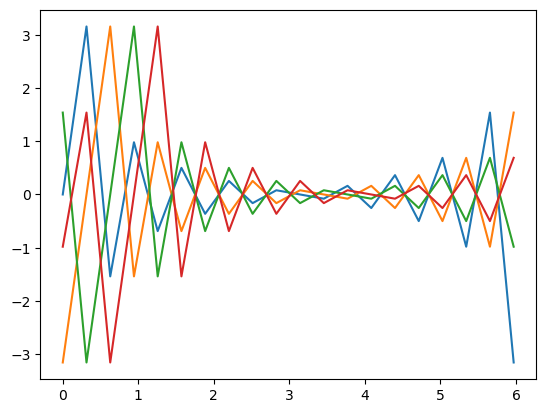

In [34]:
# # plt.plot(z_2pi, V[0:4, :].T);
plt.plot(z_2pi, D[0:4, :].T);
# plt.plot(z_2pi, D_own_lagrange[:, 0:4]);
# # plt.plot(z_2pi, Vx[0:4, :].T);

In [35]:
deriv_const = np.pi/alpha

def L_N_operator_freezing(N, deriv_const=deriv_const):

    D = get_D(N_input = N)
    z_2pi = np.linspace(0, 2*np.pi, N, endpoint=False)
    # V = constructV_Fourier(z_2pi, k = 0)
    # Vx = constructV_Fourier(z_2pi, k = 1)
    # D = np.linalg.solve(V.T, Vx.T).T
    D_3 = D @ D @ D
    z0 = u_exact_z(z_2pi, t=0)
    z0_max = np.max(np.abs(z0))

    L_N = -6 * (deriv_const) * z0_max * D - (deriv_const)**3 * D_3
    # L_N = -6 * z0_max * D - D_3

    eigenavalues, _ = sp.linalg.eig(L_N)
    eigenvalue_max = np.max(np.abs(eigenavalues))

    return eigenvalue_max

N_grid_eigenvalues = np.logspace(1, 3, 20).astype(int)
eigenvalue_max_array = np.array([L_N_operator_freezing(N) for N in tqdm(N_grid_eigenvalues)])

100%|██████████| 20/20 [00:01<00:00, 11.43it/s] 


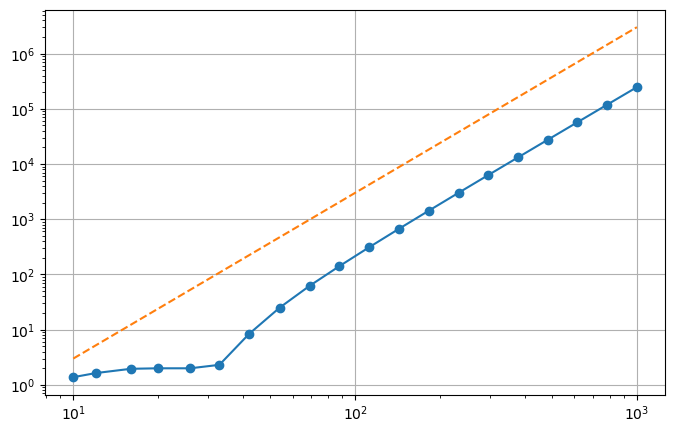

In [36]:
s = 2.7853  # eq 2.159 in https://leifh.folk.ntnu.no/teaching/tkt4140/._main025.html#:~:text=By%20substitution%20of%20%CE%BBx,as%20illstrated%20in%20figure%2023.

# Method: RK45
p = 3  # From cell below
# C = 3e-4  # From cell below
C = 3e-3

def max_time_step(N, C=C, p=p, s=s):
    return s / (C * N**p)

plt.figure(figsize = (8, 5))
plt.loglog(N_grid_eigenvalues, eigenvalue_max_array, marker = "o")
plt.loglog(N_grid_eigenvalues, C * N_grid_eigenvalues ** p, label = r"$\propto N^3$", linestyle = "--")
plt.grid();

In [41]:
# just RK4 for the temporal part
deriv_const = np.pi/alpha
# rtol = 1e-5
# atol = 1e-5
t0, tf = 0, 3


def F(t, z, D, D_3, deriv_const):
    # np.diag(z) @ D, scales O(N^3) <=> z[:, None] * D, scales O(N^2)
    # return (-6*deriv_const) * (z[:, None] * D) @ z - (deriv_const)**3 * D_3 @ z
    return (-6*deriv_const) * np.diag(z) @ D @ z - (deriv_const)**3 * D_3 @ z


def method_of_lines_KdV(N, t0, tf, deriv_const, rtol, atol, method = "RK45"):

    D = get_D(N_input = N) # in the REAL domain
    z_2pi = np.linspace(0, 2*np.pi, N, endpoint=False)
    # z_2pi = np.linspace(0, 2*np.pi, N) # WHAAAAAT 

    # V = constructV_Fourier(z_2pi, k = 0)
    # Vx = constructV_Fourier(z_2pi, k = 1)
    # D = np.linalg.solve(V.T, Vx.T).T # in the COMPLEX domain

    D_3 = D @ D @ D

    def F_wrapper(t, z):
        return F(t, z, D = D, D_3 = D_3, deriv_const = deriv_const)

    # z0 = u_exact_z(z_2pi, t=0).astype(np.complex128)
    z0 = u_exact_z(z_2pi, t=0)

    max_step = max_time_step(N)

    start = time()
    result_scipy = solve_ivp(
        F_wrapper,
        [t0, tf],
        y0 = z0,
        method = method,
        max_step = max_step,
        # rtol=rtol,
        # atol=atol
    )
    time_ode_solver = time() - start


    return result_scipy, result_scipy.t, result_scipy.y.T, z_2pi, time_ode_solver

N = 50
result_scipy, t_tmp, U_hat, z_2pi, time_ode_solver = method_of_lines_KdV(N, t0, tf, deriv_const, rtol, atol)
result_scipy

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  7.427e-03 ...  2.993e+00  3.000e+00]
        y: [[ 2.778e-11 -1.611e-06 ...  1.614e-03  1.680e-03]
            [ 7.550e-11  4.738e-07 ... -1.300e-03 -1.340e-03]
            ...
            [ 2.052e-10 -3.881e-06 ...  2.593e-03  2.615e-03]
            [ 7.550e-11  2.744e-06 ... -2.463e-03 -2.521e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 2426
     njev: 0
      nlu: 0

(405, 50) (405, 50)
0.0902724051440948


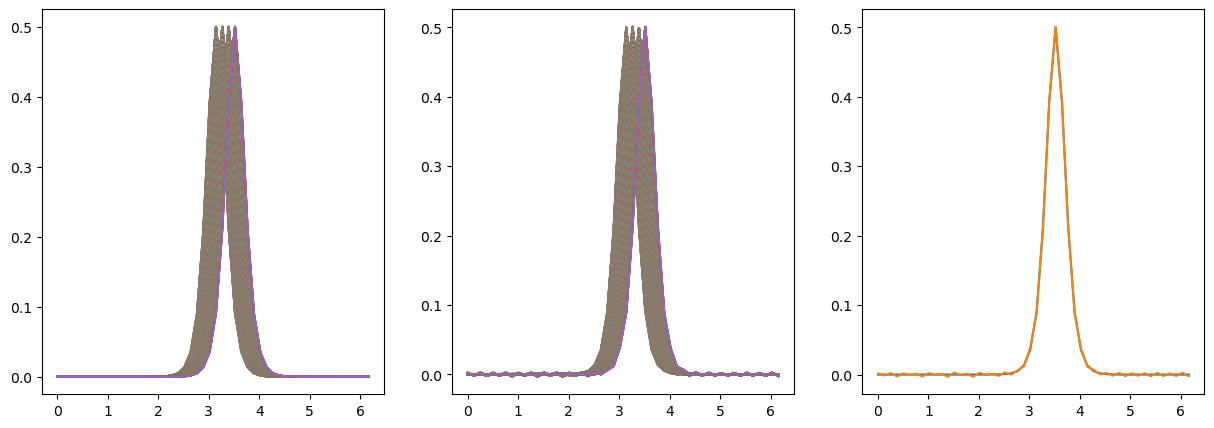

In [42]:
U_hat = U_hat.real  # drop imaginary part due to numerical errors

X_full_ivp, T_full_ivp = np.meshgrid(z_2pi, t_tmp)
U_full = u_exact_z(X_full_ivp, T_full_ivp)
print(U_full.shape, U_hat.shape)

E = U_full - U_hat
print(np.linalg.norm(E, ord=np.inf))
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(z_2pi, U_full.T);
ax[1].plot(z_2pi, U_hat.T);

ax[2].plot(z_2pi, U_full.T[:, -1]);
ax[2].plot(z_2pi, U_hat.T[:, -1]);

In [43]:
# N_max = 100
# N_grid = np.arange(2, N_max, step = 4)
N_grid = np.logspace(1, 2.3, num = 20, dtype = int)
N_grid += N_grid % 2
print(N_grid)
errors_np_inf = np.zeros(N_grid.shape[0])
errors_l2_norm = np.zeros(N_grid.shape[0])

time_ode_solver_array = np.zeros(N_grid.shape[0])

for i, N in enumerate(tqdm(N_grid)):

    result_scipy, t_tmp, U_hat, z_2pi_tmp, time_ode_solver = method_of_lines_KdV(N, t0, tf, deriv_const, rtol, atol)
    # index_filter = t_tmp < 0.4
    U_hat = U_hat.real  # drop imaginary part due to numerical errors

    X_full_ivp, T_full_ivp = np.meshgrid(z_2pi_tmp, t_tmp)
    U_full = u_exact_z(X_full_ivp, T_full_ivp)
    E = U_full - U_hat
    # E = E[index_filter, :]

    errors_np_inf[i] = np.linalg.norm(E, ord = np.inf)
    errors_l2_norm[i] = np.linalg.norm(E, ord = 'fro')
    time_ode_solver_array[i] = time_ode_solver / t_tmp.shape[0]

[ 10  12  14  16  18  22  26  30  36  42  48  56  66  78  90 106 124 146
 170 200]


100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


Text(0.5, 1.0, 'SEMILOGY')

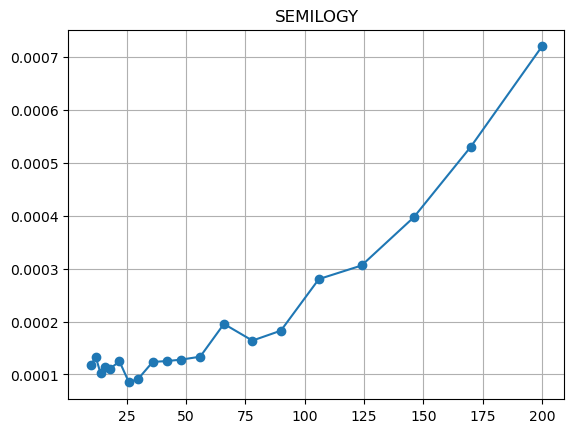

In [44]:
plt.plot(N_grid, time_ode_solver_array, marker = "o")
plt.grid()
plt.title("SEMILOGY")

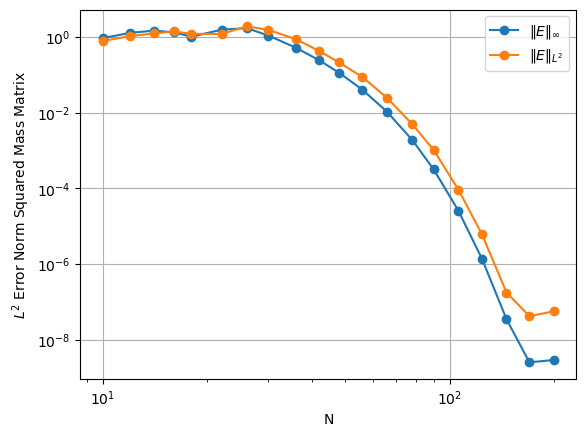

In [45]:
plt.loglog(N_grid, errors_np_inf, 'o-', label = r"$\|E\|_{\infty}$");
plt.loglog(N_grid, errors_l2_norm, 'o-', label = r"$\|E\|_{L^2}$");
plt.grid();
plt.xlabel("N")
plt.legend();
plt.ylabel(r"$L^2$ Error Norm Squared Mass Matrix");

## 2h) Advection equation

In [ ]:
c = 1
x0 = 0
alpha_coordinate = 20 # map this to [-1,1] from [0, 2pi]
a = 1

T_max = 1
# Legendre
alpha, beta = 0, 0

def f_exact(x, c=c, x0=x0): return (c/2)*(1/np.cosh((1/2)*np.sqrt(c)*(x - x0)))**2
def u_exact(x, t): return f_exact(x - c*t)

def u_exact_z(z_x, z_t, T_max=T_max, alpha_coordinate=alpha_coordinate):
    x = alpha_coordinate * z_x
    t = (T_max/2) * (z_t + 1)
    return u_exact(x, t)

def phi_0(z_x): return u_exact_z(z_x, z_t = -1)
def g_left(z_t): return u_exact_z(z_x = -1, z_t = z_t)

In [ ]:
def solve_bvp_2h(N_x, N_t):

    # N_x = N
    # N_t = N**2

    z_t = JacobiGL(alpha=alpha, beta=beta, N=N_t)
    z_x = JacobiGL(alpha=alpha, beta=beta, N=N_x)

    Z_x, Z_t = np.meshgrid(z_x, z_t, indexing='xy')

    D_t = constructD(z=z_t, alpha=alpha, beta=beta, a=-1, b=1)
    D_x = constructD(z=z_x, alpha=alpha, beta=beta, a=-1, b=1)

    # scailing factors
    D_t = (2/T_max) * D_t
    D_x = (1/alpha_coordinate) * D_x

    I_t = np.eye(N_t+1)
    I_x = np.eye(N_x+1)

    L_N = kron(D_t, I_x) + a * kron(I_t, D_x)
    L_N = L_N.toarray()

    index_helper_matrix = np.zeros(shape = (N_t+1, N_x+1))
    index_helper_matrix[0, :] = 1 # g_left(z_t = z)
    # index_helper_matrix[N, :] = 1 
    index_helper_matrix[:, 0] = 1 # phi_0(z_x = z)
    # index_helper_matrix[:, N] = 1
    index_helper_vector = index_helper_matrix.reshape(-1).astype(bool)

    index_helper = np.nonzero(index_helper_vector)[0]
    for idx in index_helper:
        L_N[idx, :] = 0
        L_N[idx, idx] = 1

    u_true = u_exact_z(Z_x, Z_t)
    
    u_BC = np.zeros(shape = (N_t+1, N_x+1))
    u_BC[0, :] = phi_0(z_x = z_x)
    u_BC[:, 0] = g_left(z_t = z_t)
    # print(np.linalg.norm(u_BC[index_helper_matrix.astype(bool)] - u_true[index_helper_matrix.astype(bool)]))

    f_matrix = np.zeros(shape = (N_t+1, N_x+1))
    f_matrix[index_helper_matrix.astype(bool)] = u_BC[index_helper_matrix.astype(bool)]
    f = f_matrix.reshape(-1)

    # print(f"{np.linalg.cond(L_N) = }")

    u = np.linalg.solve(L_N, f)

    u_matrix = u.reshape((N_t+1, N_x+1))

    l2_error_pointwise = np.linalg.norm(u_matrix - u_true, ord = np.inf)
    # print(l2_error_pointwise)

    return l2_error_pointwise, u, u_true, z, L_N, f_matrix

N_x = 200
N_t = 30
l2_error_pointwise, u, u_true, z, L_N, f_matrix = solve_bvp_2h(N_x=N_x, N_t=N_t)
print(l2_error_pointwise)

5.176697864844138e-11


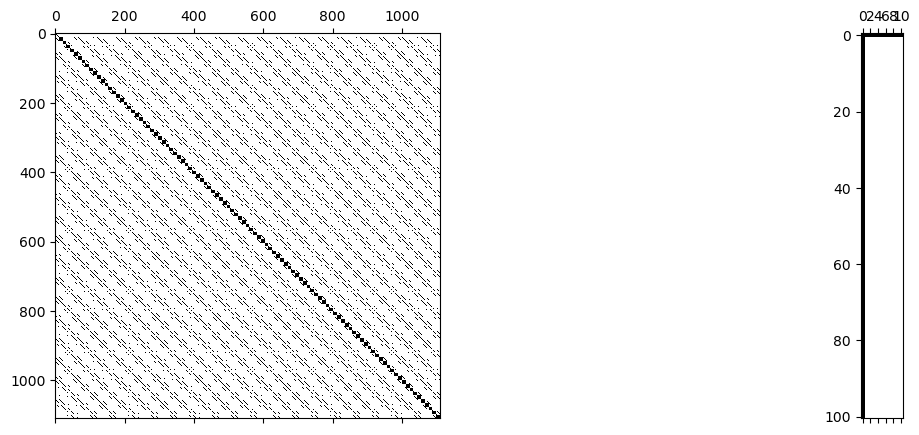

In [360]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].spy(L_N)
ax[1].spy(f_matrix)

In [420]:
N_max_x = 200
N_max_t = 50

N_grid_x = np.arange(5, N_max_x, step = 5)
# N_grid_t = np.arange(5, N_max_t, step = 5)
N_grid_t = np.array([6, 10, 16, 20, 26, 30])
# N_grid_t = np.array([10, 20, 30, 40])
# N_grid_t = N_grid_x ** 2
N_grid_x += N_grid_x % 2
N_grid_t += N_grid_t % 2

results_error_l2 = np.zeros(shape = (N_grid_t.shape[0], N_grid_x.shape[0]))
print(results_error_l2.shape)

for i_t, N_t in enumerate(tqdm(N_grid_t)):
    for i_x, N_x in enumerate(N_grid_x):
        l2_error_pointwise, u, u_true, z, L_N, f_matrix = solve_bvp_2h(N_x=N_x, N_t=N_t)
        # print(f"N_x = {N_x}, N_t = {N_t}, l2_error_pointwise = {l2_error_pointwise}")
        results_error_l2[i_t, i_x] = l2_error_pointwise

# N_grid_x_mesh, N_grid_t_mesh = np.meshgrid(N_grid_x, N_grid_t, indexing='xy')
# l2_error_pointwise, u, u_true, z, L_N, f_matrix = solve_bvp_2h(N_x = N_grid_x_mesh, N_t = N_grid_t_mesh)

(6, 39)


100%|██████████| 6/6 [00:37<00:00,  6.19s/it]


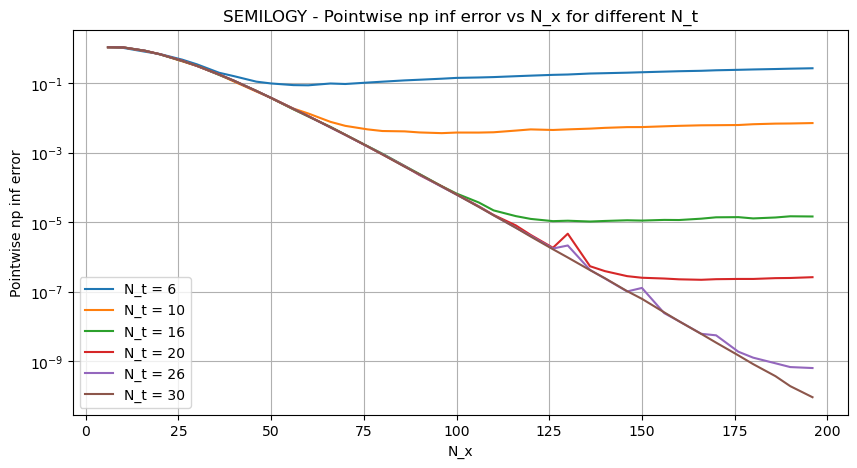

In [422]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
for i_t in range(N_grid_t.shape[0]):
    ax.semilogy(N_grid_x, results_error_l2[i_t, :], label = f"N_t = {N_grid_t[i_t]}");
ax.grid();
ax.set_xlabel("N_x")
ax.set_ylabel("Pointwise np inf error")
ax.set_title("SEMILOGY - Pointwise np inf error vs N_x for different N_t");
ax.legend();

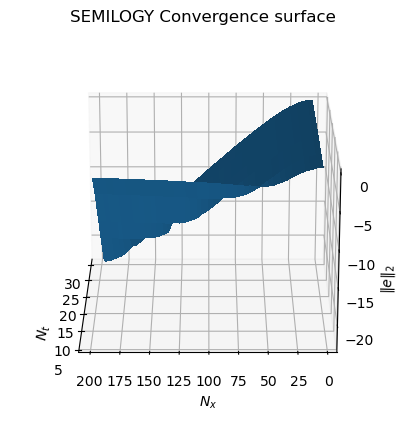

In [432]:
N_grid_x_mesh, N_grid_t_mesh = np.meshgrid(N_grid_x, N_grid_t, indexing='xy')

fig, ax = plt.subplots(1, 1, figsize = (15, 5), subplot_kw={"projection": "3d"})
# ax.plot_surface(np.log(N_grid_t_mesh), np.log(N_grid_x_mesh), np.log(results_error_l2), linewidth=0, antialiased=False, label = "Exact Solution")
ax.plot_surface(N_grid_t_mesh, N_grid_x_mesh, np.log(results_error_l2),
    linewidth=0, antialiased=False, label = "Exact Solution")
ax.view_init(20, -180)
ax.set_xlabel(r'$N_t$')
ax.set_ylabel(r'$N_x$')
ax.set_zlabel(r'$\|e\|_2$')
ax.set_title('SEMILOGY Convergence surface')
plt.show()

In [467]:
# N_grid = np.arange(5, 150, step = 2)
N_max = 200
N_grid = np.arange(5, N_max, step = 5)
N_grid += N_grid % 2
errors_l2_2 = np.zeros(N_grid.shape[0])

N_t = 30
for i, N in enumerate(tqdm(N_grid)):
    # N_x, N_t = N, N
    # N_x, N_t = N, N**2
    N_x = N
    l2_error_pointwise, u, u_true, z, L_N, f_matrix = solve_bvp_2h(N_x = N_x, N_t = N_t)
    errors_l2_2[i] = l2_error_pointwise

100%|██████████| 39/39 [00:13<00:00,  2.93it/s]


In [462]:
# plt.loglog(errors_l2_2[::2], label = "Even N_x")
# plt.loglog(errors_l2_2[1::2], label = "Odd N_x");
# plt.grid();
# plt.legend();

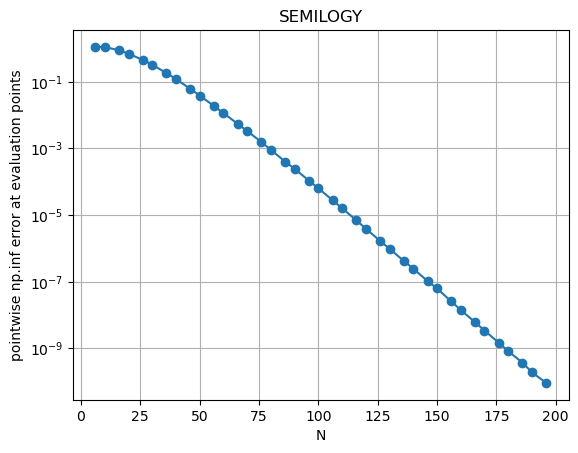

In [468]:
plt.semilogy(N_grid, errors_l2_2, 'o-')
plt.grid();
plt.xlabel("N")
plt.title("SEMILOGY")
plt.ylabel(r"pointwise np.inf error at evaluation points");

## Appendix